Run an EasyVVUQ campaign to analyze the sensitivity for the Ishigami function with noise

This is done with PCE providing a normal distributed noise value

In [1]:
# Run an EasyVVUQ campaign to analyze the sensitivity for the Ishigami function with noise
# This is done with PCE providing a normal distributed noise value.
import os
import easyvvuq as uq
import chaospy as cp
import pickle
import numpy as np
import matplotlib.pylab as plt
import time
import pandas as pd

In [2]:
# Define the Ishigami function
def ishigamiSA(a,b):
    '''Exact sensitivity indices of the Ishigami function for given a and b.
    From https://openturns.github.io/openturns/master/examples/meta_modeling/chaos_ishigami.html
    '''
    var = 1.0/2 + a**2/8 + b*np.pi**4/5 + b**2*np.pi**8/18
    S1 = (1.0/2 + b*np.pi**4/5+b**2*np.pi**8/50)/var
    S2 = (a**2/8)/var
    S3 = 0
    S13 = b**2*np.pi**8/2*(1.0/9-1.0/25)/var
    exact = {
            'expectation' : a/2,
            'variance' : var,
            'S1' : (1.0/2 + b*np.pi**4/5+b**2*np.pi**8.0/50)/var,
            'S2' : (a**2/8)/var,
            'S3' : 0,
            'S12' : 0,
            'S23' : 0,
            'S13' : S13,
            'S123' : 0,
            'ST1' : S1 + S13,
            'ST2' : S2,
            'ST3' : S3 + S13
            }
    return exact

Ishigami_a = 7.0
Ishigami_b = 0.1
exact = ishigamiSA(Ishigami_a, Ishigami_b)

In [3]:
# define a model to run the Ishigami code directly from python, expecting a dictionary and returning a dictionary
def run_ishigami_model(input):
    import Ishigami
    qois = ["Ishigami"]
    del input['out_file']
    N = input['N']
    del input['N']
    return {qois[0]: Ishigami.evaluate(**input)+N}

In [4]:
# Define parameter space
def define_params():
    return {
        "x1":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x2":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x3":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "a":        {"type": "float",   "min": Ishigami_a, "max": Ishigami_a, "default": Ishigami_a},
        "b":        {"type": "float",   "min": Ishigami_b, "max": Ishigami_b, "default": Ishigami_b},
        "N":        {"type": "float",   "min": -100.0,     "max": 100.0,      "default": 0.0},
        "out_file": {"type": "string",  "default": "output.csv"}
    }

In [5]:
# Define varying space
def define_vary():
    return {
        "x1":   cp.Uniform(-np.pi, np.pi),
        "x2":   cp.Uniform(-np.pi, np.pi),
        "x3":   cp.Uniform(-np.pi, np.pi),
        "N":    cp.Normal(0, 10.0)
    }

In [6]:
# Set up and run a campaign
def run_campaign(pce_order=2, use_files=False):

    times = np.zeros(7)

    time_start = time.time()
    time_start_whole = time_start

    # Set up a fresh campaign called "Ishigami_pce."
    my_campaign = uq.Campaign(name='Ishigami_pce.')

    # Create an encoder and decoder for PCE test app
    if use_files:
        encoder = uq.encoders.GenericEncoder(template_fname='Ishigami.template',
                                             delimiter='$',
                                             target_filename='Ishigami_in.json')

        decoder = uq.decoders.SimpleCSV(target_filename="output.csv",
                                        output_columns=["Ishigami"])

        execute = uq.actions.ExecuteLocal('python3 %s/Ishigami.py Ishigami_in.json' % (os.getcwd()))

        actions = uq.actions.Actions(uq.actions.CreateRunDirectory('/tmp'), 
                          uq.actions.Encode(encoder), execute, uq.actions.Decode(decoder))
    else:
        actions = uq.actions.Actions(uq.actions.ExecutePython(run_ishigami_model))

    # Add the app (automatically set as current app)
    my_campaign.add_app(name="Ishigami", params=define_params(), actions=actions)

    # Create the sampler
    time_end = time.time()
    times[1] = time_end-time_start
    print('Time for phase 1 = %.3f' % (times[1]))

    time_start = time.time()
    # Associate a sampler with the campaign
    Sampler_PCE = uq.sampling.PCESampler(vary=define_vary(), polynomial_order=pce_order)
    my_campaign.set_sampler(Sampler_PCE)

    # Will draw all (of the finite set of samples)
    my_campaign.draw_samples()
    print('PCE order = %s' % pce_order)
    print('Number of samples = %s' % my_campaign.get_active_sampler().count)

    time_end = time.time()
    times[2] = time_end-time_start
    print('Time for phase 2 = %.3f' % (times[2]))

    time_start = time.time()
    # Run the cases
    my_campaign.execute(sequential=True).collate(progress_bar=True)

    time_end = time.time()
    times[3] = time_end-time_start
    print('Time for phase 3 = %.3f' % (times[3]))

    time_start = time.time()
    # Get the results
    results_df = my_campaign.get_collation_result()

    time_end = time.time()
    times[4] = time_end-time_start
    print('Time for phase 4 = %.3f' % (times[4]))

    time_start = time.time()
    # Post-processing analysis
    results = my_campaign.analyse(qoi_cols=["Ishigami"])
    
    time_end = time.time()
    times[5] = time_end-time_start
    print('Time for phase 5 = %.3f' % (times[5]))

    time_start = time.time()
    # Save the results
    pickle.dump(results, open('Ishigami_results.pickle','bw'))
    time_end = time.time()
    times[6] = time_end-time_start
    print('Time for phase 6 = %.3f' % (times[6]))

    times[0] = time_end - time_start_whole

    return results_df, results, times, pce_order, my_campaign.get_active_sampler().count

In [7]:
# Calculate the polynomial chaos expansion for a range of orders

R = {}
for pce_order in range(1, 11):
    R[pce_order] = {}
    (R[pce_order]['results_df'], 
     R[pce_order]['results'], 
     R[pce_order]['times'], 
     R[pce_order]['order'], 
     R[pce_order]['number_of_samples']) = run_campaign(pce_order=pce_order, use_files=False)

Time for phase 1 = 0.026
PCE order = 1
Number of samples = 16
Time for phase 2 = 0.070


100%|████████████████████████████████████████████████| 16/16 [00:00<00:00, 2804.15it/s]

Time for phase 3 = 0.021
Time for phase 4 = 0.032
Time for phase 5 = 0.054
Time for phase 6 = 0.003
Time for phase 1 = 0.011


PCE order = 2
Number of samples = 81
Time for phase 2 = 0.124


100%|████████████████████████████████████████████████| 81/81 [00:00<00:00, 3330.87it/s]

Time for phase 3 = 0.033
Time for phase 4 = 0.004
Time for phase 5 = 0.133
Time for phase 6 = 0.001
Time for phase 1 = 0.008


PCE order = 3
Number of samples = 256
Time for phase 2 = 0.207


100%|██████████████████████████████████████████████| 256/256 [00:00<00:00, 4990.55it/s]

Time for phase 3 = 0.062
Time for phase 4 = 0.005


Time for phase 5 = 0.269
Time for phase 6 = 0.001
Time for phase 1 = 0.008
PCE order = 4
Number of samples = 625
Time for phase 2 = 0.421


100%|██████████████████████████████████████████████| 625/625 [00:00<00:00, 5099.29it/s]

Time for phase 3 = 0.143
Time for phase 4 = 0.012


Time for phase 5 = 0.656
Time for phase 6 = 0.001
Time for phase 1 = 0.007
PCE order = 5
Number of samples = 1296
Time for phase 2 = 0.774


100%|████████████████████████████████████████████| 1296/1296 [00:00<00:00, 2887.71it/s]


Time for phase 3 = 0.498
Time for phase 4 = 0.109
Time for phase 5 = 2.258
Time for phase 6 = 0.002
Time for phase 1 = 0.018
PCE order = 6
Number of samples = 2401
Time for phase 2 = 1.281


100%|████████████████████████████████████████████| 2401/2401 [00:00<00:00, 4844.01it/s]


Time for phase 3 = 0.560
Time for phase 4 = 0.092
Time for phase 5 = 5.140
Time for phase 6 = 0.002
Time for phase 1 = 0.015
PCE order = 7
Number of samples = 4096
Time for phase 2 = 1.867


100%|████████████████████████████████████████████| 4096/4096 [00:00<00:00, 5006.41it/s]


Time for phase 3 = 0.943
Time for phase 4 = 0.107
Time for phase 5 = 13.187
Time for phase 6 = 0.014
Time for phase 1 = 0.024
PCE order = 8
Number of samples = 6561
Time for phase 2 = 3.065


100%|████████████████████████████████████████████| 6561/6561 [00:01<00:00, 5320.48it/s]


Time for phase 3 = 1.469
Time for phase 4 = 0.089
Time for phase 5 = 34.744
Time for phase 6 = 0.005
Time for phase 1 = 0.019
PCE order = 9
Number of samples = 10000
Time for phase 2 = 4.579


100%|██████████████████████████████████████████| 10000/10000 [00:01<00:00, 5055.38it/s]


Time for phase 3 = 2.305
Time for phase 4 = 0.256
Time for phase 5 = 85.647
Time for phase 6 = 0.008
Time for phase 1 = 0.016
PCE order = 10
Number of samples = 14641
Time for phase 2 = 7.401


100%|██████████████████████████████████████████| 14641/14641 [00:02<00:00, 5216.68it/s]


Time for phase 3 = 3.314
Time for phase 4 = 0.266
Time for phase 5 = 169.084
Time for phase 6 = 0.009


In [8]:
# save the results

pickle.dump(R, open('collected_results.pickle','bw'))

In [9]:
# produce a table of the time taken for various phases
# the phases are:
#   1: creation of campaign
#   2: creation of samples
#   3: running the cases
#   4: calculation of statistics including Sobols
#   5: returning of analysed results
#   6: saving campaign and pickled results

Timings = pd.DataFrame(np.array([R[r]['times'] for r in list(R.keys())]), 
             columns=['Total', 'Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 5', 'Phase 6'], 
             index=[R[r]['order'] for r in list(R.keys())])
Timings.to_csv(open('Timings.csv', 'w'))
display(Timings)

,Total,Phase 1,Phase 2,Phase 3,Phase 4,Phase 5,Phase 6
1,0.206571,0.026080,0.070131,0.020785,0.032049,0.054390,0.002557
2,0.305832,0.010971,0.124241,0.033282,0.003821,0.132683,0.000605
3,0.552754,0.007502,0.207028,0.062329,0.005470,0.269407,0.000714
4,1.240322,0.008090,0.421225,0.142600,0.011607,0.655824,0.000745
5,3.649108,0.007265,0.773599,0.498296,0.108962,2.258257,0.001887
6,7.094146,0.018417,1.280857,0.559989,0.092320,5.140118,0.001978
7,16.133547,0.015276,1.867243,0.943253,0.106865,13.186906,0.013542
8,39.397349,0.024417,3.064570,1.469353,0.088808,34.744386,0.005351
9,92.814330,0.019228,4.578781,2.305010,0.255850,85.646646,0.008496
10,180.090970,0.015762,7.400623,3.313908,0.265976,169.084253,0.009452


/Volumes/Samsung8TB/dpc/GIT/EasyVVUQ/env/lib/python3.9/site-packages/easyvvuq-1.1+0.g6b4d4dda.dirty-py3.9.egg/easyvvuq/analysis/results.py:417: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


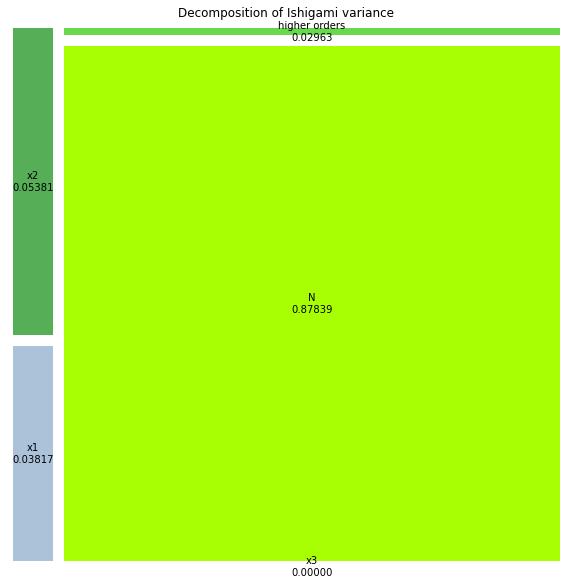

In [10]:
R[10]['results'].plot_sobols_treemap('Ishigami')

In [11]:
R[10]['results'].sobols_first(), R[10]['results'].sobols_total()

({'Ishigami': {'x1': array([0.03817368]),
   'x2': array([0.05380603]),
   'x3': array([1.60762508e-29]),
   'N': array([0.87838626])}},
 {'Ishigami': {'x1': array([0.06780771]),
   'x2': array([0.05380603]),
   'x3': array([0.02963403]),
   'N': array([0.87838626])}})

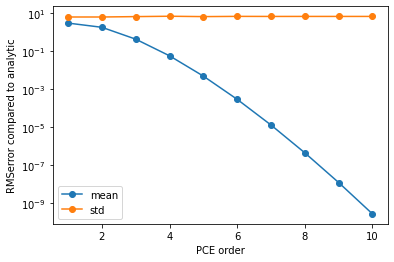

In [12]:
# plot the convergence of the mean and standard deviation to the analytic result

mean_analytic = exact['expectation']
std_analytic = np.sqrt(exact['variance'])

O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
plt.semilogy([o for o in O], 
             [np.abs(R[o]['results'].describe('Ishigami', 'mean') - mean_analytic) for o in O],
             'o-', label='mean')
plt.semilogy([o for o in O], 
             [np.abs(R[o]['results'].describe('Ishigami', 'std') - std_analytic) for o in O],
             'o-', label='std')
plt.xlabel('PCE order')
plt.ylabel('RMSerror compared to analytic')
plt.legend(loc=0)
plt.savefig('Convergence_mean_std.png')
plt.savefig('Convergence_mean_std.pdf')

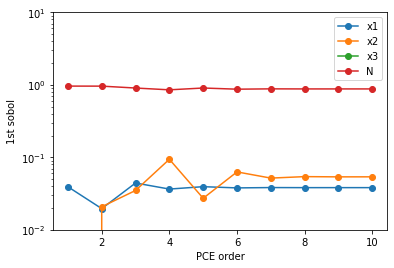

In [13]:
# plot the first Sobols as a function of PCE order
O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
for v in list(R[O[0]]['results'].sobols_first('Ishigami').keys()):
    plt.semilogy([o for o in O],
                 [R[o]['results'].sobols_first('Ishigami')[v] for o in O],
                 'o-',
                 label=v)
plt.xlabel('PCE order')
plt.ylabel('1st sobol')
plt.ylim(1e-2,10)
plt.legend(loc=0)
plt.savefig('Convergence_sobol_first.png')
plt.savefig('Convergence_sobol_first.pdf')

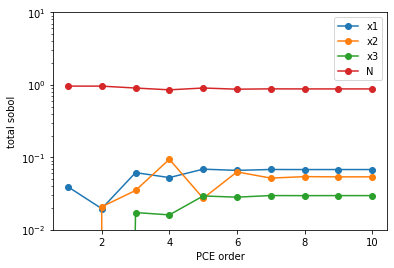

In [14]:
# plot the total Sobols as a function of PCE order
O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
for v in list(R[O[0]]['results'].sobols_total('Ishigami').keys()):
    plt.semilogy([o for o in O],
                 [R[o]['results'].sobols_total('Ishigami')[v] for o in O],
                 'o-',
                 label=v)
plt.xlabel('PCE order')
plt.ylabel('total sobol')
plt.ylim(1e-2,10)
plt.legend(loc=0)
plt.savefig('Convergence_sobol_total.png')
plt.savefig('Convergence_sobol_total.pdf')

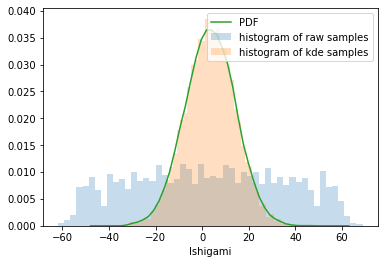

In [15]:
# plot the distribution function

results_df = R[O[-1]]['results_df']
results = R[O[-1]]['results']
Ishigami_dist = results.raw_data['output_distributions']['Ishigami']

plt.figure()
plt.hist(results_df.Ishigami[0], density=True, bins=50, label='histogram of raw samples', alpha=0.25)
if hasattr(Ishigami_dist, 'samples'):
    plt.hist(Ishigami_dist.samples[0], density=True, bins=50, label='histogram of kde samples', alpha=0.25)
t1 = Ishigami_dist[0]
plt.plot(np.linspace(t1.lower, t1.upper), t1.pdf(np.linspace(t1.lower, t1.upper)), label='PDF')
plt.legend(loc=0)
plt.xlabel('Ishigami')
plt.savefig('Ishigami_distribution_function.png')

In [21]:
results_df.Ishigami[0]

0       -52.525277
1       -40.006931
2       -29.296497
3       -19.405615
4        -9.933955
           ...    
14636     9.999347
14637    19.471007
14638    29.361888
14639    40.072323
14640    52.590669
Name: 0, Length: 14641, dtype: float64

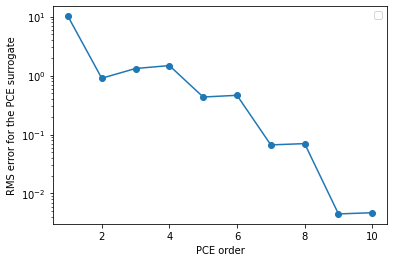

In [17]:
# plot the RMS surrogate error at the PCE sample points
_o = []
_RMS = []
for r in R.values():
    results_df = r['results_df']
    results = r['results']
    Ishigami_surrogate = np.squeeze(np.array(results.surrogate()(results_df[results.inputs])['Ishigami']))
    Ishigami_samples = np.squeeze(np.array(results_df['Ishigami']))
    _RMS.append((np.sqrt((((Ishigami_surrogate - Ishigami_samples))**2).mean())))
    _o.append(r['order'])

plt.figure()
plt.semilogy(_o, _RMS, 'o-')
plt.xlabel('PCE order')
plt.ylabel('RMS error for the PCE surrogate')
plt.legend(loc=0)
plt.savefig('Convergence_surrogate.png')
plt.savefig('Convergence_surrogate.pdf')

In [18]:
# prepare the test data
test_campaign = uq.Campaign(name='Ishigami.')        
test_campaign.add_app(name="Ishigami", params=define_params(), 
                      actions=uq.actions.Actions(uq.actions.ExecutePython(run_ishigami_model)))
test_campaign.set_sampler(uq.sampling.quasirandom.LHCSampler(vary=define_vary(), count=100))
test_campaign.execute(nsamples=1000, sequential=True).collate(progress_bar=True)
test_df = test_campaign.get_collation_result()

100%|████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5315.98it/s]


In [19]:
# calculate the PCE surrogates
test_points = test_df[test_campaign.get_active_sampler().vary.get_keys()]
test_results = np.squeeze(test_df['Ishigami'].values)
test_predictions = {}
for i in list(R.keys()):
    test_predictions[i] = np.squeeze(np.array(R[i]['results'].surrogate()(test_points)['Ishigami']))

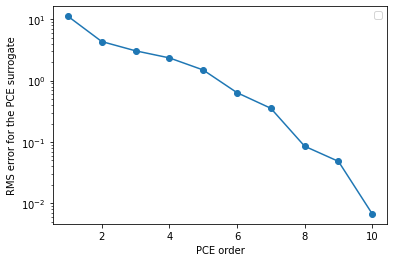

In [20]:
# plot the convergence of the surrogate
_o = []
_RMS = []
for r in R.values():
    _RMS.append((np.sqrt((((test_predictions[r['order']] - test_results))**2).mean())))
    _o.append(r['order'])

plt.figure()
plt.semilogy(_o, _RMS, 'o-')
plt.xlabel('PCE order')
plt.ylabel('RMS error for the PCE surrogate')
plt.legend(loc=0)
plt.savefig('Convergence_PCE_surrogate.png')
plt.savefig('Convergence_PCE_surrogate.pdf')